In [1236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PROJEKT
## GOOGLE STORE RATING
### Katarzyna Sobczyszyn

In [1237]:
import os

from keras.callbacks import History
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from mlxtend.evaluate import  accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv(os.path.join("googleplaystore.csv"))
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## OPIS DANYCH

In [1238]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


## OBRÓBKA DANYCH

### Niepotrzebne kolumny i null wartości

In [1239]:
# data.drop_duplicates(subset='App', inplace=True, ignore_index=True)
cols = ['Current Ver', 'Android Ver']
print("Usuwam kolumnę unikalnych wartości 'App' ")
print("Usuwam kolumnę 'Current Ver' bo liczba kategorii to : ", data['Current Ver'].nunique())
print("Usuwam kolumnę 'Android Ver' bo zawiera :", len(data.loc[data['Android Ver'] == 'Varies with device']),
      "nieprecyzyjnych danych")
data = data[data['Content Rating'].isin(['Adults only 18+', 'Unrated']) == False]
data = data.drop(cols, axis=1)
data.dropna(inplace=True)
print('Liczba aplikacji : ', len(data))

Usuwam kolumnę unikalnych wartości 'App' 
Usuwam kolumnę 'Current Ver' bo liczba kategorii to :  2832
Usuwam kolumnę 'Android Ver' bo zawiera : 1362 nieprecyzyjnych danych
Liczba aplikacji :  9362


### Podstawowe Poprawki

#### Zmieniam 'Price' by była liczbą (usuwam '$')

In [1240]:
data['Price'] = data['Price'].apply(lambda x: x.strip('$')).astype(float)

#### Zmieniam 'Installs' by była liczbą (usuwam '+')

In [1241]:
data['Installs'] = data['Installs'].apply(lambda x: x.strip('+').replace(',', '')).astype('int')

#### Zmieniam 'Reviews' by była liczbą

In [1242]:
data['Reviews'] = data['Reviews'].astype('int')

#### Zmieniam 'Size' by była liczbą (w MB)

In [1243]:
size = []
for i in data['Size']:
    if i == 'Varies with device':
        size.append(20)
    elif i[-1] == 'k':
        size.append(float(i[:-1]) / 1000)
    else:
        size.append(float(i[:-1]))

data['Size'] = size
data['Size'] = data['Size'].astype('float')

#### Zmieniam 'Last Updated' na bardziej precyzyjne kolumny (rok i miesiąc)

In [1244]:
data['Last Updated Year'] = pd.to_datetime(data['Last Updated']).dt.year

In [1245]:
data['Last Updated Month'] = pd.to_datetime(data['Last Updated']).dt.month

In [1246]:
data = data.drop('Last Updated', axis=1)

In [1247]:
data['App'] = data['App'].str.len()

# PO PODSTAWOWEJ OBRÓBCE

In [1248]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated Year,Last Updated Month
0,46,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,2018,1
1,19,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018,1
2,50,ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,2018,8
3,21,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,2018,6
4,37,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,2018,6


In [1249]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9362 entries, 0 to 10840
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   App                 9362 non-null   int64  
 1   Category            9362 non-null   object 
 2   Rating              9362 non-null   float64
 3   Reviews             9362 non-null   int64  
 4   Size                9362 non-null   float64
 5   Installs            9362 non-null   int64  
 6   Type                9362 non-null   object 
 7   Price               9362 non-null   float64
 8   Content Rating      9362 non-null   object 
 9   Genres              9362 non-null   object 
 10  Last Updated Year   9362 non-null   int64  
 11  Last Updated Month  9362 non-null   int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 950.8+ KB


## Korelacje

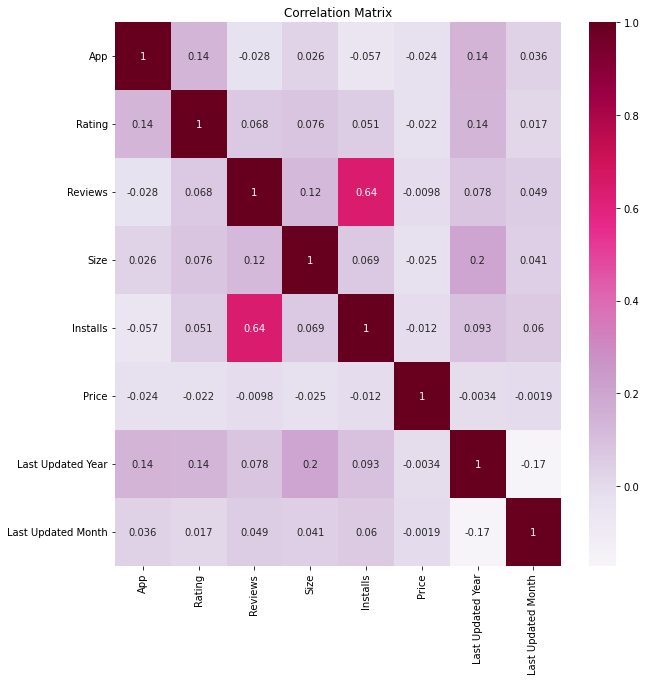

In [1250]:
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, cmap='PuRd')
plt.title('Correlation Matrix')
plt.show()

## Rating

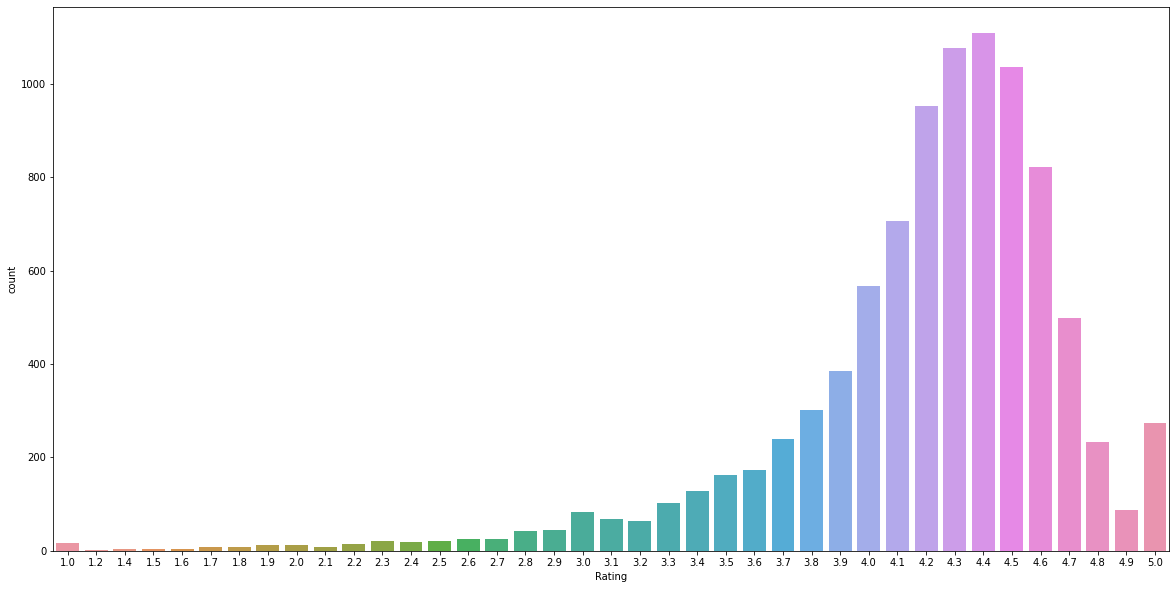

In [1251]:
plt.figure(figsize=(20, 10))
sns.countplot(x='Rating', data=data)
plt.show()

## Installs

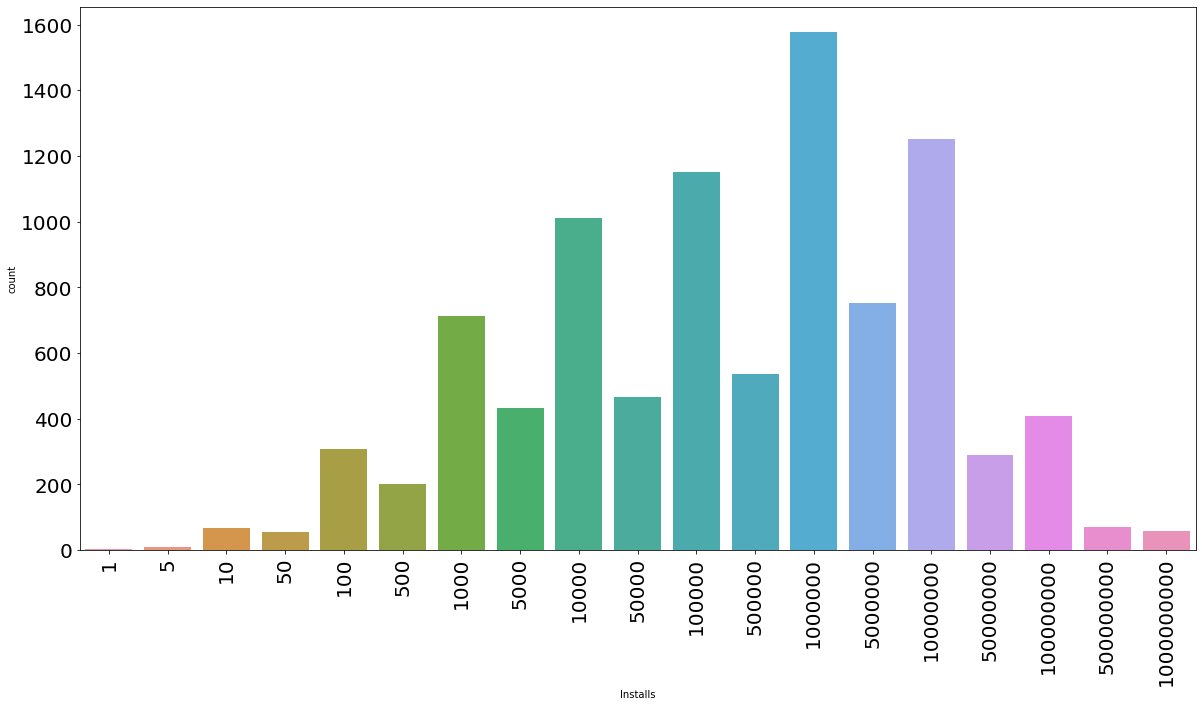

In [1252]:
plt.figure(figsize=(20, 10))
sns.countplot(x='Installs', data=data)
plt.yticks(fontsize=20)
plt.xticks(rotation=90, fontsize=20)
plt.show()

## Category

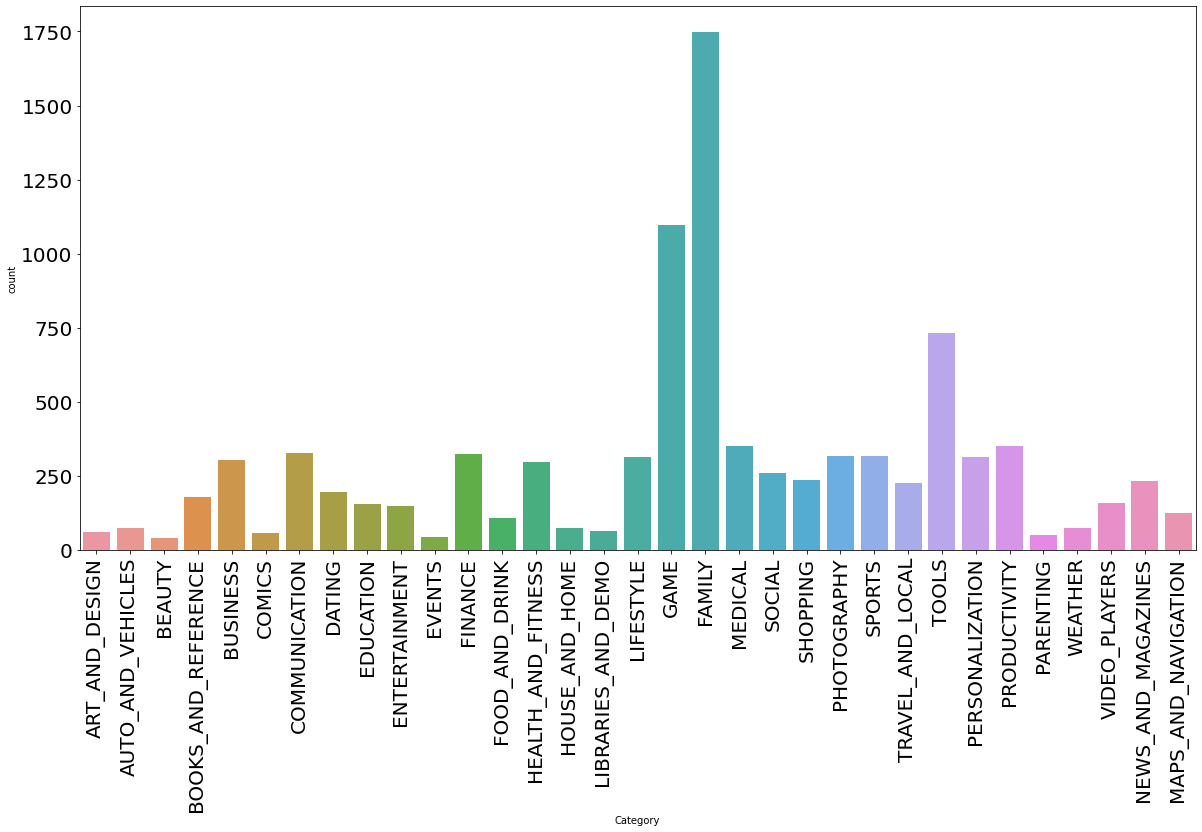

In [1253]:
plt.figure(figsize=(20, 10))
sns.countplot(x='Category', data=data)
plt.yticks(fontsize=20)
plt.xticks(rotation=90, fontsize=20)
plt.show()

## Type

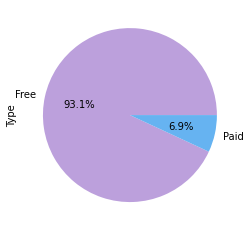

In [1254]:
data['Type'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#bca0dc', '#66b3f1'])
plt.show()

## Type vs rating

In [1255]:
data.groupby('Type').describe()[['Rating']].T

Type                 Free        Paid
Rating count  8715.000000  647.000000
       mean      4.186173    4.266615
       std       0.512408    0.547523
       min       1.000000    1.000000
       25%       4.000000    4.100000
       50%       4.300000    4.400000
       75%       4.500000    4.600000
       max       5.000000    5.000000

## Content rating

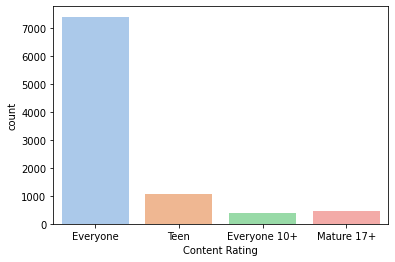

In [1256]:
sns.countplot(x='Content Rating', data=data, palette='pastel')
plt.show()

## Content rating vs rating

In [1257]:
data.groupby('Content Rating').describe()[['Rating']].T

Content Rating     Everyone  Everyone 10+  Mature 17+         Teen
Rating count    7420.000000    397.000000  461.000000  1084.000000
       mean        4.186375      4.257179    4.123427     4.233487
       std         0.537377      0.367259    0.505765     0.391595
       min         1.000000      1.800000    1.000000     2.000000
       25%         4.000000      4.100000    4.000000     4.000000
       50%         4.300000      4.300000    4.200000     4.300000
       75%         4.500000      4.500000    4.400000     4.500000
       max         5.000000      5.000000    5.000000     5.000000

## Last Updated Year

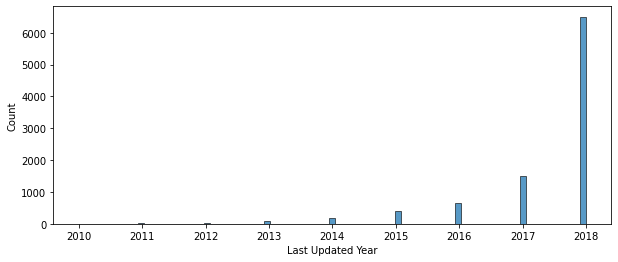

In [1258]:
plt.figure(figsize=(10, 4))
sns.histplot(x='Last Updated Year', data=data)
plt.show()

## Last Updated Month

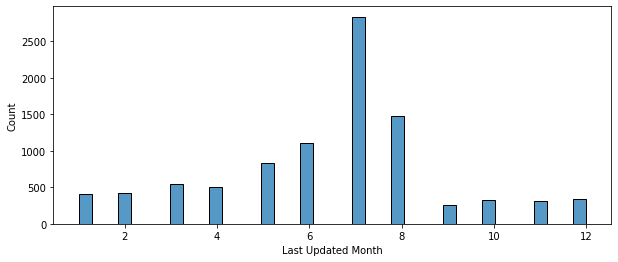

In [1259]:
plt.figure(figsize=(10, 4))
sns.histplot(x='Last Updated Month', data=data)
plt.show()

In [1260]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data['Content Rating'] = le.fit_transform(data['Content Rating'])
data['Category'] = le.fit_transform(data['Category'])
data['Type'] = le.fit_transform(data['Type'])
data['Genres'] = le.fit_transform(data['Genres'])

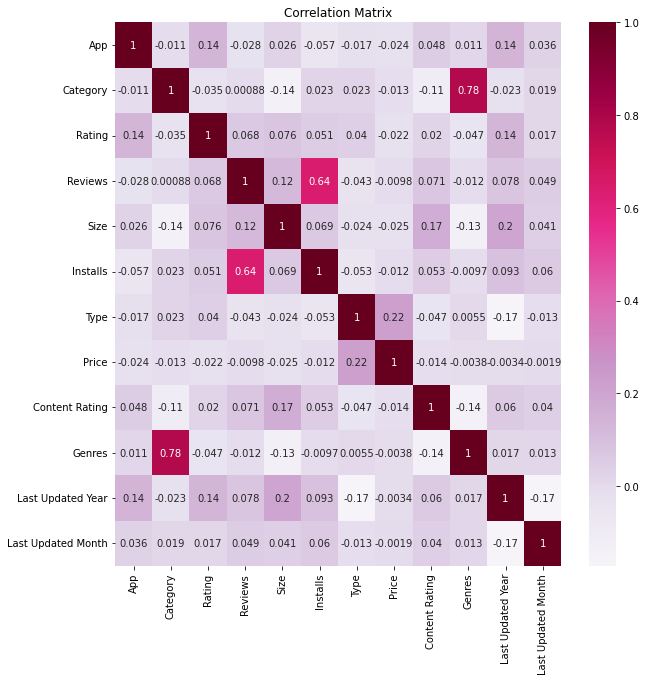

In [1261]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, cmap='PuRd')
plt.title('Correlation Matrix')
plt.show()

In [1262]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated Year,Last Updated Month
0,46,0,4.1,159,19.0,10000,0,0.0,0,9,2018,1
1,19,0,3.9,967,14.0,500000,0,0.0,0,11,2018,1
2,50,0,4.7,87510,8.7,5000000,0,0.0,0,9,2018,8
3,21,0,4.5,215644,25.0,50000000,0,0.0,3,9,2018,6
4,37,0,4.3,967,2.8,100000,0,0.0,0,10,2018,6


In [1263]:
data = data.drop(['Price', 'Category', 'Genres'], axis=1)
data.head()

,App,Rating,Reviews,Size,Installs,Type,Content Rating,Last Updated Year,Last Updated Month
0,46,4.1,159,19.0,10000,0,0,2018,1
1,19,3.9,967,14.0,500000,0,0,2018,1
2,50,4.7,87510,8.7,5000000,0,0,2018,8
3,21,4.5,215644,25.0,50000000,0,3,2018,6
4,37,4.3,967,2.8,100000,0,0,2018,6


## Kategorie:

In [1264]:
X = data.drop('Rating', axis=1).values
y = (data['Rating'] * 10).values
print("Z zakresu")
print(np.unique(y))
print("Rozkład w kategoriach:")
print(data['Rating'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print('\nW tym przypadku predykcje są prawdziwe\n Są lepsze niż wybranie kategorii dominującej')

Z zakresu
[10. 12. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.
 48. 49. 50.]
Rozkład w kategoriach:
4.4    11.8%
4.3    11.5%
4.5    11.1%
4.2    10.2%
4.6     8.8%
4.1     7.6%
4.0     6.1%
4.7     5.3%
3.9     4.1%
3.8     3.2%
5.0     2.9%
3.7     2.6%
4.8     2.5%
3.6     1.9%
3.5     1.7%
3.4     1.4%
3.3     1.1%
4.9     0.9%
3.0     0.9%
3.1     0.7%
3.2     0.7%
2.9     0.5%
2.8     0.4%
2.7     0.3%
2.6     0.3%
2.5     0.2%
2.3     0.2%
2.4     0.2%
1.0     0.2%
2.2     0.1%
1.9     0.1%
2.0     0.1%
1.7     0.1%
1.8     0.1%
2.1     0.1%
1.6     0.0%
1.4     0.0%
1.5     0.0%
1.2     0.0%
Name: Rating, dtype: object

W tym przypadku predykcje są prawdziwe
 Są lepsze niż wybranie kategorii dominującej


In [1265]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [1266]:
classifiers = [KNeighborsClassifier(n_neighbors=20),
               RandomForestClassifier(n_estimators=20, criterion='entropy', random_state=0),
               DecisionTreeClassifier(criterion='entropy', random_state=0)]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    predict = classifier.predict(X_test)
    score = accuracy_score(predict, y_test)
    print(classifier.__class__.__name__[:30])
    print('Accuracy: ' + str(np.round(score * 100, 2)) + '%')


KNeighborsClassifier
Accuracy: 15.91%
RandomForestClassifier
Accuracy: 26.37%
DecisionTreeClassifier
Accuracy: 25.95%


## Przy mniejszej liczbie kategorii:

In [1267]:
X = data.drop('Rating', axis=1).values
y = data['Rating'].values
y = y.astype('int')
print("Z zakresu:")
print(np.unique(y))
print("Można uzyskać dużo dokładniejsze wyniki,\nale nie jest to wartościowe bo rating z przedziału [4.0,4.9] stanowi")
print(str(np.round(
    data['Rating'].loc[(data['Rating'] > 3.9) & (data['Rating'] < 5.0)].count() / data['Rating'].count() * 100,
    2)) + '%')

Z zakresu:
[1 2 3 4 5]
Można uzyskać dużo dokładniejsze wyniki,
ale nie jest to wartościowe bo rating z przedziału [4.0,4.9] stanowi
75.74%


In [1268]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
classifiers = [KNeighborsClassifier(n_neighbors=20),
               RandomForestClassifier(n_estimators=20, criterion='entropy', random_state=0),
               DecisionTreeClassifier(criterion='entropy', random_state=0)]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    predict = classifier.predict(X_test)
    score = accuracy_score(predict, y_test)
    print(classifier.__class__.__name__[:30])
    print('Accuracy: ' + str(np.round(score * 100, 2)) + '%')

KNeighborsClassifier
Accuracy: 74.69%
RandomForestClassifier
Accuracy: 75.6%
DecisionTreeClassifier
Accuracy: 70.74%


In [1269]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

print(keras.__version__)

2.8.0
2.8.0


In [1270]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.preprocessing import MinMaxScaler

seed = 10
np.random.seed(seed)
X = data.drop('Rating', axis=1).values

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
print('means ', X.mean(axis=0))
print('std: ', X.std(axis=0))


y = (data['Rating']).values
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
input_dim = len(data.columns) - 1
class_dim = 39
y = np_utils.to_categorical(y)


train_x, test_x, train_y, test_y = train_test_split(X,y,test_size = 0.2, random_state = 0)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

means  [0.11499967 0.00657972 0.22435945 0.01790487 0.06910916 0.16275012
 0.92753952 0.4955332 ]
std:  [0.06447193 0.04023282 0.21330549 0.09125213 0.25363968 0.34043575
 0.13767611 0.22809352]
(7489, 8)
(7489, 39)
(1873, 8)
(1873, 39)


In [1271]:
def basic_model():
    models = []
    for opt in ['adam','SGD']:
        model = Sequential()
        model.add(Dense(128, input_dim = input_dim , activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dropout(0.2))
        model.add(Dense(class_dim, activation = 'softmax') )
        model.compile(loss = 'categorical_crossentropy' , optimizer = opt , metrics = ['accuracy'] )
        models.append(model)
    return models

In [1272]:
def extended_model():
    models = []
    for opt in ['adam','SGD']:
        model = Sequential()
        model.add(Dense(128, input_dim = input_dim , activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Activation('relu'))
        model.add(Dense(64))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Activation('relu'))
        model.add(Dense(class_dim, activation = 'softmax') )
        model.compile(loss = 'categorical_crossentropy' , optimizer = opt , metrics = ['accuracy'] )
        models.append(model)
    return models

In [1273]:
def run_and_display_model(mod2):
    history = History()
    mod2.fit(train_x, train_y, validation_data= (test_x, test_y), batch_size=32,epochs=100, callbacks=[history,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
    scores = mod2.evaluate(test_x, test_y)
    print("\n%s: %.2f%%" % (mod2.metrics_names[1], scores[1]*100))
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 4)
    plt.show()
    plt.plot(history.history['loss'], label = "train loss")
    plt.plot(history.history['val_loss'], label = "test val_loss")
    plt.legend()
    plt.show()

adam
Epoch 1/100
235/235 [==============================] - 2s 5ms/step - loss: 2.9739 - accuracy: 0.1038 - val_loss: 2.8428 - val_accuracy: 0.1068

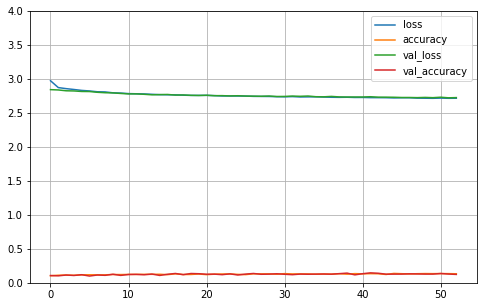

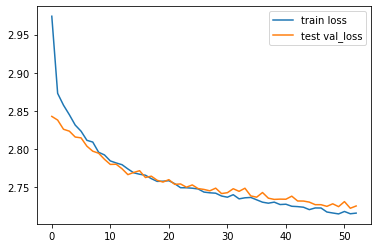

SGD
Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 3.2411 - accuracy: 0.0996 - val_loss: 2.9709 - val_accuracy: 0.1121
Epoch 2/100
235/235 [==============================] - 0s 2ms/step - loss: 2.9595 - accuracy: 0.1168 - val_loss: 2.8976 - val_accuracy: 0.1

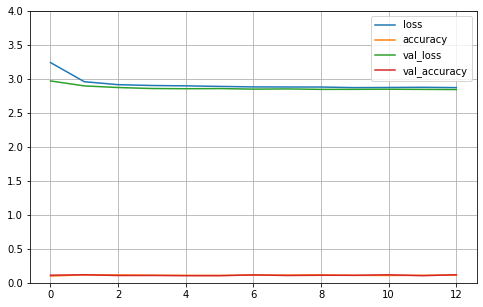

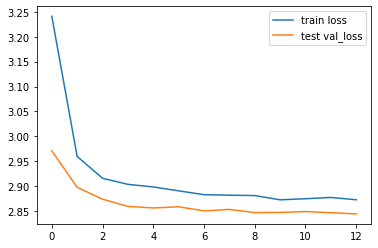

In [1274]:
opt = ['adam','SGD']
models = basic_model()
for i in range(2):
    print(opt[i])
    run_and_display_model(models[i])

adam
Epoch 1/100
235/235 [==============================] - 2s 4ms/step - loss: 3.1685 - accuracy: 0.1023 - val_loss: 2.9302 - val_accuracy: 0.1132

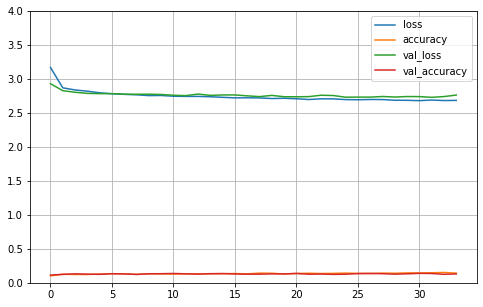

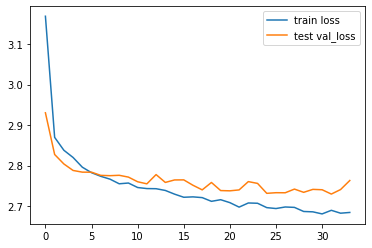

SGD
Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 3.5677 - accuracy: 0.0781 - val_loss: 3.2717 - val_accuracy: 0.1196
Epoch 2/100
235/235 [==============================] - 

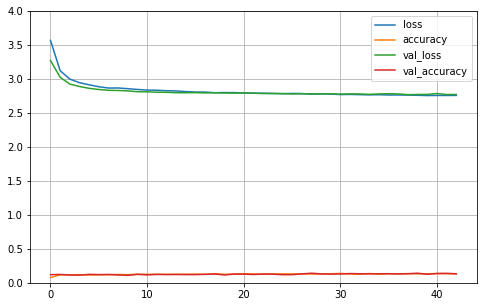

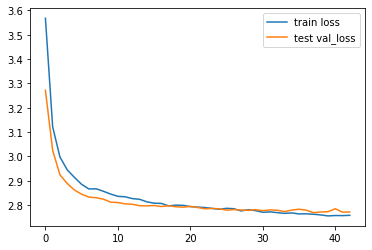

In [1275]:
opt = ['adam','SGD']
models = extended_model()
for i in range(2):
    print(opt[i])
    run_and_display_model(models[i])

Wnioski z doboru modeli:
- Bardziej rozbudowany model zazwyczaj osiąga lepsze wyniki
- Early stopping wskazuje na to że dłuższa nauka modeli nie daje lepszych wyników
- Adami SGD dają podobne wyniki

# WNIOSKI
- Modele głębokie nie dają specjnalnych efektów
- Działają minimalnie lepiej niż przypisywanie najliczniejszej klasy
- Niezależnie od liczby kategorii ( czy 5 czy 39 klas )accuracy nie poprawia się
- Lepsze efekty dają modele płytkie
- Zbiór danych nie jest zbytnio "uczalny"